<img src="Pictures/Heading.jpg" width="1500" height = "600">

<img src="Pictures/sec1.jpg" width="1500" height = "300">

In [2]:
'''
------------------------------------------------------------------------
DATASET : https://www.kaggle.com/datasets/masaladata/14-million-cell-phone-reviews
------------------------------------------------------------------------
'''

import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import tensorflow as tf # deep learning
from tensorflow.keras.models import Sequential # deep learning
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation # deep learning
from nltk.corpus import stopwords # natural language processing
from pyspark.sql import functions # data processing
from pyspark.ml.feature import StopWordsRemover # natural language processing
from keras.preprocessing.text import Tokenizer # natural language processing
import pyspark.pandas as ps # data processing
from nltk.stem import PorterStemmer # natural language processing
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D # deep learning
from nltk import pos_tag #Tags words with their parts of speech
from nltk.corpus import stopwords #Contains a list of stopwords
from nltk.corpus import wordnet #Contains a list of wordnet words
from keras_preprocessing.sequence import pad_sequences
from sklearn.base import BaseEstimator, TransformerMixin #Base class for transformers
from sklearn.pipeline import make_pipeline #Used to create a pipeline
import nbformat #Used to read the notebook
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer #Counts the number of times a word appears in a document
from nltk.stem import WordNetLemmatizer #Let's you lemmatize words
from nltk.corpus import wordnet #Contains a list of wordnet words
import seaborn as sns #Used to create visualizations
from sklearn.metrics import confusion_matrix #Used to create a confusion matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
'''
---------------------------------------------------------------------------------------------------------------------
****IMPORTANT****

TO INSALL THE WORDCLOUD LIBRARY, YOU MAY NEED TO RUN THE CODE BELOW IN A NEW CELL

%pip install https://github.com/sulunemre/word_cloud/releases/download/2/wordcloud-0.post1+gd8241b5-cp310-cp310-win_amd64.whl

JUST COPY AND PASTE THE ENTIRE LINE (INCLUDING THE % SIGN) INTO A NEW CELL AND RUN IT
---------------------------------------------------------------------------------------------------------------------
'''
from wordcloud import WordCloud #Used to generate a word cloud


In [3]:
'''
------------------------------------------------------------------------------------------------------------------------
The below code are the functions used to clean the data.
The classes are designed to fit inside of a pipeline.
------------------------------------------------------------------------------------------------------------------------
'''
def sentiment_rating(rating):
    # Replacing ratings of 4,5 with 1 (good) and 1,2 with 0 (not good)
    if(float(rating) > 6):
        return 1
    else: 
        return 0

def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text): #Lemmatize the words
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            pos = pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(word.lower())
    return " ".join(final_text)

class Lemmatize(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['extract'] = X['extract'].apply(lemmatize_words)
        return X

class removeStopWords(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['extract'] = X['extract'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
        return X

class StemTheWords(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):       
        X['extract'] = X['extract'].apply(lambda x: " ".join(PorterStemmer().stem(word) for word in x.split()))
        return X
    
class dropTheNullValues(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.dropna()
    
class getRelevantColumns(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[['extract', 'score']]
    
class returnXAndY(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.iloc[:,0],X.iloc[:,1]
       

class convertYtoBinary(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['score'] = X['score'].apply(sentiment_rating)
        return X

class makeItLowerCase(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['extract'] = X['extract'].str.lower()        
        return X
    
class replaceHTMLelements(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['extract'] = X['extract'].str.replace('<.*?>', '')       
        return X
    
class onlyTakeEnglishRecords(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X[X['lang'] == 'en']        
        return X

class convertObjectColumnsToStringColumns(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        string_col = X.select_dtypes(include="object").columns
        X[string_col] = X[string_col].astype("string")
        return X

In [65]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's import the files which we will be using for this task
Since we aren't doing much cleaning on the data at this point, pandas will be used to import the data into
a pandas dataframe, which is easy to work with and fast to visualise.
------------------------------------------------------------------------------------------------------------------------
When we clean the data, more intensive tasks will be preformed, at which point spark will be utilized.
------------------------------------------------------------------------------------------------------------------------
'''
files = os.listdir('Phone Reviews') # get all the files in the directory
print(files) # print the files

dataframes = [] # create an empty list
for file in files: # loop through the files
    if file.endswith('.csv'): # if the file ends with .csv, but exclude the first file which we already loaded
        dataframes.append(pd.read_csv('Phone Reviews/' + file, encoding='latin-1')) # append the spark dataframe to the list
        
masterFrame = pd.concat(dataframes) # concatenate the dataframes into one dataframe
masterFrame.head() # print the first 5 rows of the dataframe

['phone_user_review_file_1.csv', 'phone_user_review_file_2.csv', 'phone_user_review_file_3.csv', 'phone_user_review_file_4.csv', 'phone_user_review_file_5.csv', 'phone_user_review_file_6.csv']


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


In [66]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's see how many records there are in the dataframe.
As well as some basic info.
------------------------------------------------------------------------------------------------------------------------
'''
masterFrame.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1415133 entries, 0 to 163836
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   phone_url  1415133 non-null  object 
 1   date       1415133 non-null  object 
 2   lang       1415133 non-null  object 
 3   country    1415133 non-null  object 
 4   source     1415133 non-null  object 
 5   domain     1415133 non-null  object 
 6   score      1351644 non-null  float64
 7   score_max  1351644 non-null  float64
 8   extract    1395772 non-null  object 
 9   author     1351931 non-null  object 
 10  product    1415132 non-null  object 
dtypes: float64(2), object(9)
memory usage: 129.6+ MB


In [67]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's do some very basic cleaning of the data.
We want to see which countries participated the most in the reviews.
------------------------------------------------------------------------------------------------------------------------
So we are going to grab the country and the score. And then create a new dataframe with the count.
------------------------------------------------------------------------------------------------------------------------
'''
countryAndScore = masterFrame[['country', 'score']]
pipeline = make_pipeline(dropTheNullValues(), convertObjectColumnsToStringColumns())
countryAndScore = pipeline.fit_transform(countryAndScore)
print(countryAndScore.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1351644 entries, 0 to 163836
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   country  1351644 non-null  string 
 1   score    1351644 non-null  float64
dtypes: float64(1), string(1)
memory usage: 30.9 MB
None


C:\Users\kglez\AppData\Local\Temp\ipykernel_24152\359894739.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[string_col] = X[string_col].astype("string")


In [68]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's grab the count of each country.
------------------------------------------------------------------------------------------------------------------------
'''
CountFrame = countryAndScore['country'].value_counts().to_frame().reset_index()

'''
------------------------------------------------------------------------------------------------------------------------
Rename the index column to country and the country column to count.
------------------------------------------------------------------------------------------------------------------------
'''
CountFrame = CountFrame.rename(columns={'index':'country', 'country':'count'})
CountFrame.head(10)

,country,count
0,us,313438
1,de,172982
2,ru,167156
3,in,127873
4,it,112729
5,gb,95725
6,fr,84242
7,es,76021
8,br,54378
9,ua,31433


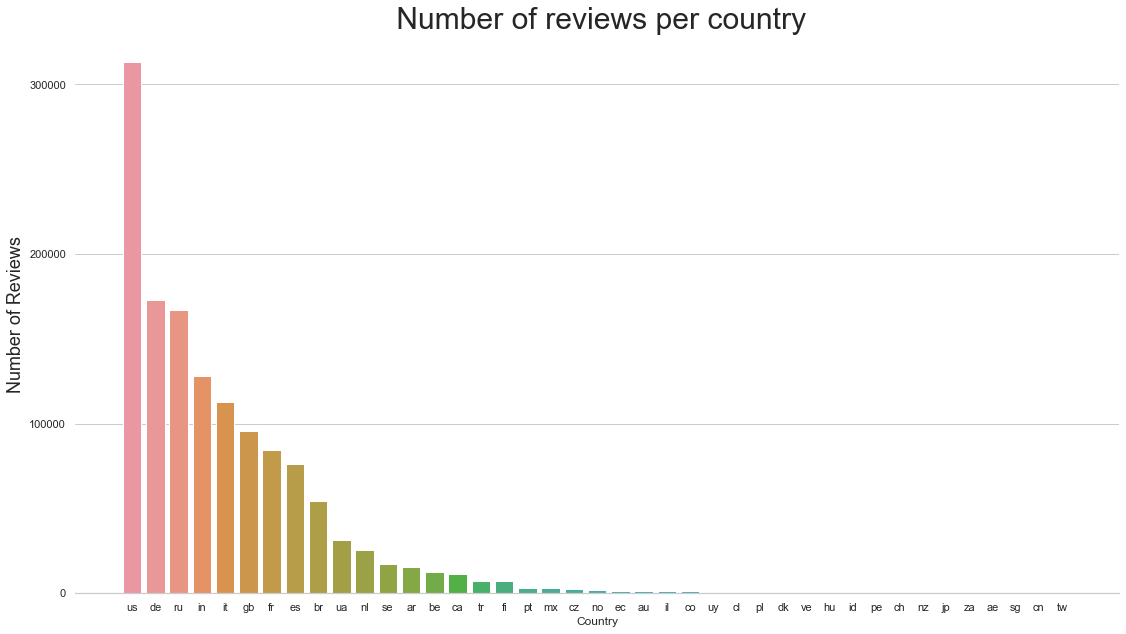

In [69]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's create a basic graph function which takes the dataframe and the title.
------------------------------------------------------------------------------------------------------------------------
'''
def plotBarGraph(dataframe, title,X,y):
    sns.set(rc={'figure.figsize':(18.7,10.27)})

    sns.set(style="whitegrid")
    sns.barplot(data=dataframe, x=X, y=y)
    plt.xlabel('Country')
    plt.ylabel('Number of Reviews', size=18)
    plt.title(title, size = 30)
    sns.despine(left=True)
    sns.set(font_scale=4)
    #Plot it
    plt.plot()

'''
------------------------------------------------------------------------------------------------------------------------
Let's output a bargraph of all the countries to get an idea of participation.
------------------------------------------------------------------------------------------------------------------------
'''
plotBarGraph(CountFrame, " Number of reviews per country", "country", "count")

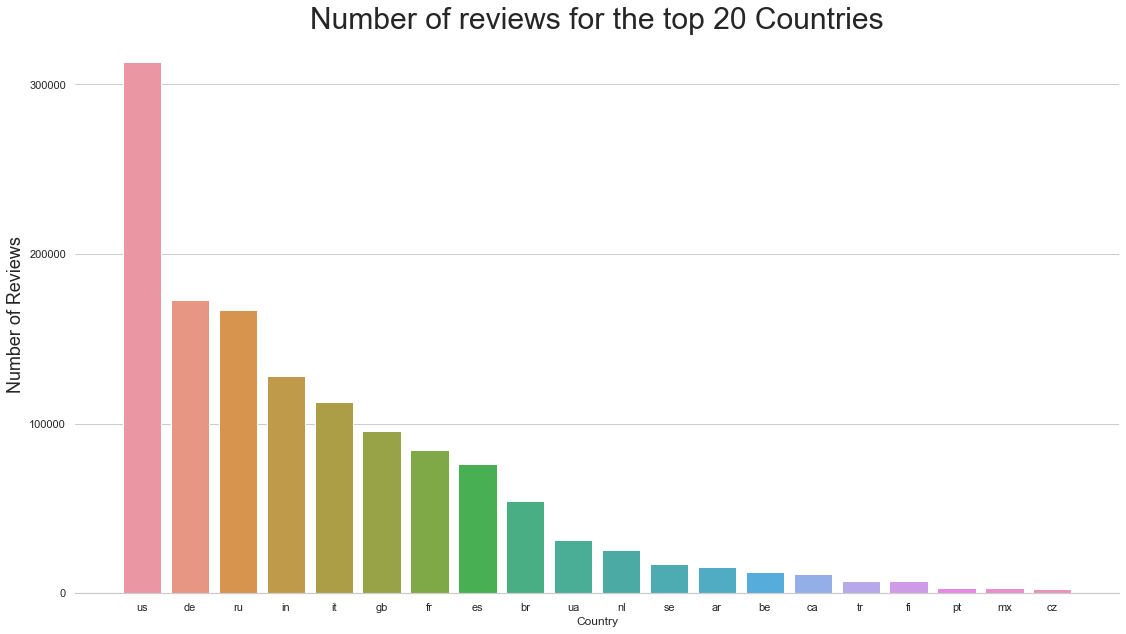

In [70]:
'''
------------------------------------------------------------------------------------------------------------------------
We see that there are a lot of countries which have very few reviews.
So let's break the countries into upper and lower.
------------------------------------------------------------------------------------------------------------------------
'''
top20 = CountFrame.head(20)
bottom20 = CountFrame.tail(20)

'''
------------------------------------------------------------------------------------------------------------------------
Let's output the top 20 countries.
------------------------------------------------------------------------------------------------------------------------
'''
plotBarGraph(top20, "Number of reviews for the top 20 Countries","country", "count")

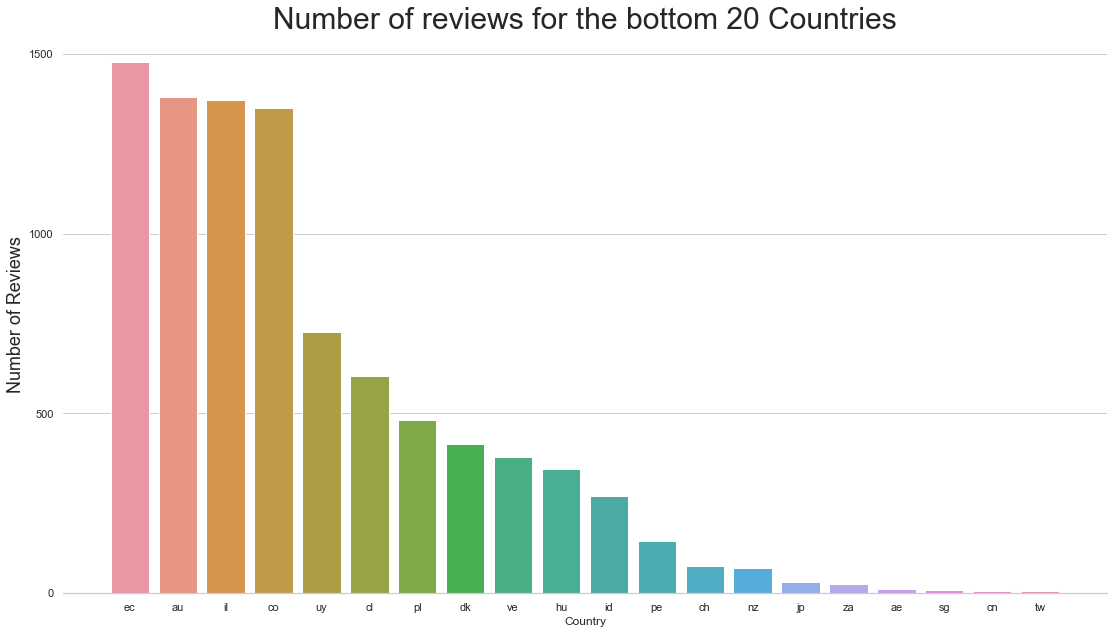

In [71]:
'''
------------------------------------------------------------------------------------------------------------------------
Immediately we see that the United States (US), Germany (DE), and Russia (RU) are the top 3 countries.
But there is more infomation we can gain here.
First, however, let's see if there is anything interesting about the bottom countries.
------------------------------------------------------------------------------------------------------------------------
'''
plotBarGraph(bottom20, "Number of reviews for the bottom 20 Countries","country", "count")

In [72]:
'''
------------------------------------------------------------------------------------------------------------------------
There doesn't seem to be anything in spectacular about the bottom countries.
The lack of records brings into question how this dataset was collected.
------------------------------------------------------------------------------------------------------------------------
Let's see which percentage of each country had positive reviews.
------------------------------------------------------------------------------------------------------------------------
We are also only going to use records with more than 1000 revirews.
This ensures that the sample size is adequate.
------------------------------------------------------------------------------------------------------------------------
'''
#Only take countries with more than 1000 reviews
CountFrame = CountFrame[CountFrame['count'] > 1000]
countries = CountFrame['country'].to_list()

'''
------------------------------------------------------------------------------------------------------------------------
First we take only the records which are relevant to us.
------------------------------------------------------------------------------------------------------------------------
'''
relevantFrame = countryAndScore[countryAndScore['country'].isin(countries)]
relevantFrame = relevantFrame.dropna()
'''
------------------------------------------------------------------------------------------------------------------------
We then apply the sentiment rating function to the score column.
------------------------------------------------------------------------------------------------------------------------
'''
relevantFrame['sentiment'] = relevantFrame['score'].apply(sentiment_rating)

'''
------------------------------------------------------------------------------------------------------------------------
Afterwards when create an empty series and store the sum of the sentiment column for each country.
------------------------------------------------------------------------------------------------------------------------
'''
series = pd.Series(name='amount')
for country in countries:
    series = series.append(pd.Series([relevantFrame[relevantFrame['country'] == country]['sentiment'].sum()], index=[country]))
series = series.reset_index() 
'''
------------------------------------------------------------------------------------------------------------------------
Afterwards we concat the series with the countFrame.
------------------------------------------------------------------------------------------------------------------------
'''
CountFrame = pd.concat([CountFrame, series], axis=1)
CountFrame = CountFrame.rename(columns={0:'Percentage Above 6 stars','index':'temp1'})
'''
------------------------------------------------------------------------------------------------------------------------
Next we want the percentage of positive reviews.
------------------------------------------------------------------------------------------------------------------------
'''
for index, row in CountFrame.iterrows():
    #calculate the percentage of positive reviews
    CountFrame.at[index, 'Percentage Above 6 stars'] = int((row['Percentage Above 6 stars'] / row['count']) * 100)
PercentFrame = CountFrame.drop(columns=['temp1', 'count'])
PercentFrame

C:\Users\kglez\AppData\Local\Temp\ipykernel_24152\255011633.py:35: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pd.Series(name='amount')
C:\Users\kglez\AppData\Local\Temp\ipykernel_24152\255011633.py:37: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  series = series.append(pd.Series([relevantFrame[relevantFrame['country'] == country]['sentiment'].sum()], index=[country]))
C:\Users\kglez\AppData\Local\Temp\ipykernel_24152\255011633.py:37: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  series = series.append(pd.Series([relevantFrame[relevantFrame['country'] == country]['sentiment'].sum()], index=[country]))
C:\Users\kglez\AppData\Local\Temp\ipykernel_24152\255011633.py:37: FutureWarning: 

,country,Percentage Above 6 stars
0,us,70
1,de,74
2,ru,76
3,in,67
4,it,82
5,gb,76
6,fr,74
7,es,76
8,br,83
9,ua,84


[]

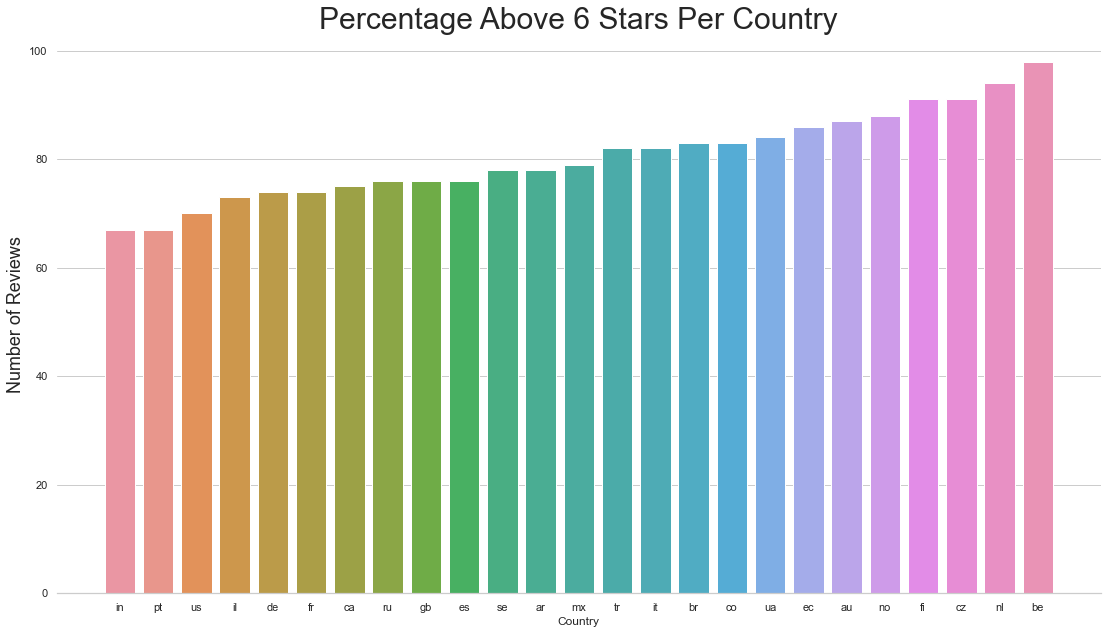

In [73]:
#Sort percentage frame by percentage
PercentFrame = PercentFrame.sort_values(by=['Percentage Above 6 stars'], ascending=True)

sns.set(rc={'figure.figsize':(18.7,10.27)})
sns.set(style="whitegrid")
sns.barplot(data=PercentFrame, x="country", y="Percentage Above 6 stars")
plt.xlabel('Country')
plt.ylabel('Number of Reviews', size=18)
plt.title('Percentage Above 6 Stars Per Country', size = 30)
sns.despine(left=True)
sns.set(font_scale=4)
#Plot it
plt.plot()

In [74]:
'''
------------------------------------------------------------------------------------------------------------------------
We see that India and Portugal have the lowest percentage of positive reviews.
While Belgium and the Netherlands have the highest percentage of positive reviews.
------------------------------------------------------------------------------------------------------------------------
And interesting idea here would be to very heavily encourage people in Belgium and Netherlands to write reviews.
While not nessicaresarily discouraging people in India and Portugal, but atleast not encouraging them.
------------------------------------------------------------------------------------------------------------------------
But there may still be more at play here.
Let's perform and example of how we could maybe play with this idea for a certain phone.
------------------------------------------------------------------------------------------------------------------------
Let's take the score and product from the master frame
------------------------------------------------------------------------------------------------------------------------
'''
productFrame = masterFrame[['country','score', 'product']]
productFrame

,country,score,product
0,us,10.0,Samsung Galaxy S8
1,us,10.0,Samsung Galaxy S8
2,us,6.0,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,us,9.2,Samsung Galaxy S8 64GB (AT&T)
4,us,4.0,Samsung Galaxy S8
...,...,...,...
163832,de,2.0,Alcatel Club Plus Handy
163833,de,10.0,Alcatel Club Plus Handy
163834,de,2.0,Alcatel Club Plus Handy
163835,de,8.0,Alcatel Club Plus Handy


In [75]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's take the S8 for instance.
Let's only take records which are about the Samsung Galaxy S8.
There are quite a few variations of the S8.
And we want to include all of them.
------------------------------------------------------------------------------------------------------------------------
'''
productFrame = productFrame.dropna()
productFrame = productFrame[productFrame['product'].str.contains('Samsung Galaxy S8')]
productFrame

,country,score,product
0,us,10.0,Samsung Galaxy S8
1,us,10.0,Samsung Galaxy S8
2,us,6.0,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,us,9.2,Samsung Galaxy S8 64GB (AT&T)
4,us,4.0,Samsung Galaxy S8
...,...,...,...
5789,it,10.0,"Samsung Galaxy S8+ Smartphone, 64 GB, Nero"
5790,de,10.0,Samsung Galaxy S8 Plus Smartphone mit 64 GB in...
5791,de,10.0,Samsung Galaxy S8 Plus Smartphone mit 64 GB in...
5792,no,10.0,Samsung Galaxy S8+ smarttelefon (sort)


In [76]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's convert the score to int values.
------------------------------------------------------------------------------------------------------------------------
'''
def convertScoreToInt(score):
    return int(score)

productFrame['score'] = productFrame['score'].apply(convertScoreToInt)
productFrame

,country,score,product
0,us,10,Samsung Galaxy S8
1,us,10,Samsung Galaxy S8
2,us,6,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,us,9,Samsung Galaxy S8 64GB (AT&T)
4,us,4,Samsung Galaxy S8
...,...,...,...
5789,it,10,"Samsung Galaxy S8+ Smartphone, 64 GB, Nero"
5790,de,10,Samsung Galaxy S8 Plus Smartphone mit 64 GB in...
5791,de,10,Samsung Galaxy S8 Plus Smartphone mit 64 GB in...
5792,no,10,Samsung Galaxy S8+ smarttelefon (sort)


Text(0, 0.5, 'Number of Reviews')

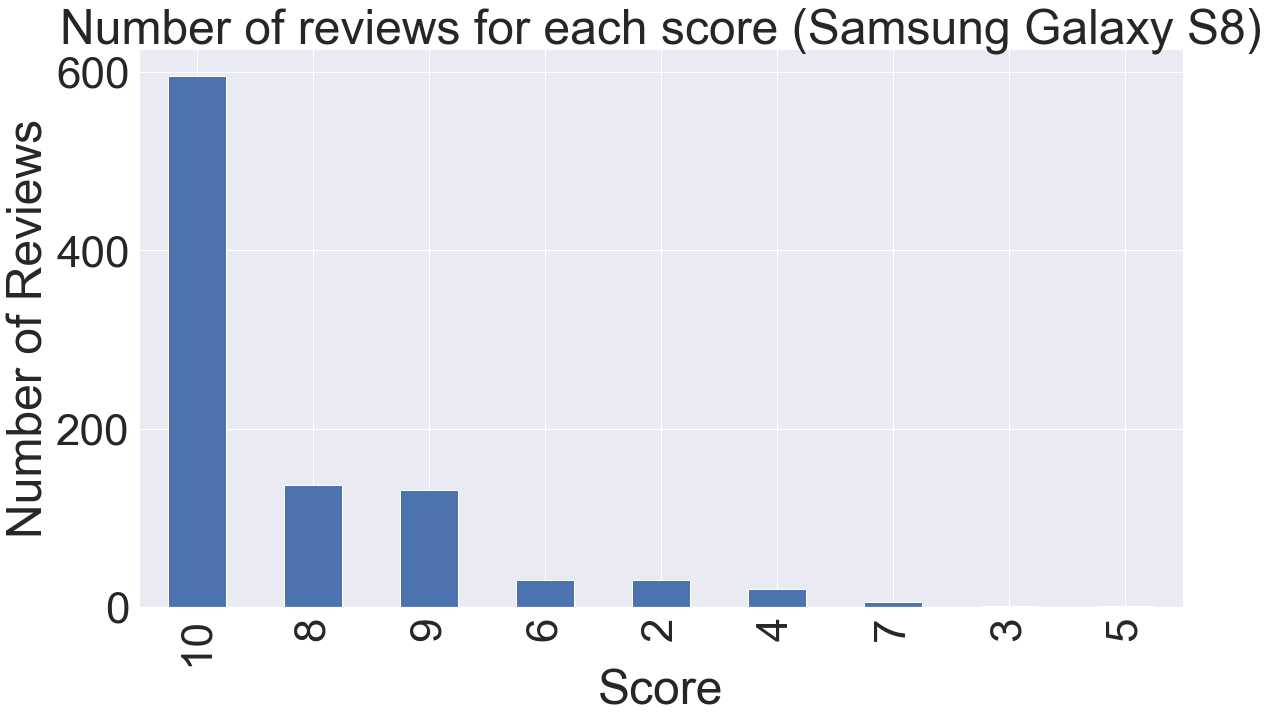

In [77]:
'''
------------------------------------------------------------------------------------------------------------------------
This will make it easy to see how many of each score there are.
------------------------------------------------------------------------------------------------------------------------
'''
productFrame['score'].value_counts().plot(kind='bar')
plt.title('Number of reviews for each score (Samsung Galaxy S8)')
plt.xlabel('Score')
plt.ylabel('Number of Reviews')

In [78]:
'''
------------------------------------------------------------------------------------------------------------------------
Now let's see what the average rating is for each country.
------------------------------------------------------------------------------------------------------------------------
'''
average = productFrame.groupby('country')['score'].mean().sort_values(ascending=False)
average

country
br    10.000000
cz    10.000000
ua    10.000000
gb     9.831579
se     9.818182
de     9.545455
ru     9.333333
au     9.125000
fr     9.120000
nl     9.092784
no     9.062500
fi     9.000000
it     8.956522
us     8.726457
il     8.571429
in     8.500000
es     8.000000
be     7.500000
Name: score, dtype: float64

In [79]:
'''
------------------------------------------------------------------------------------------------------------------------
It's really nice to see that some countries like brazil have 100% 10 star reviews.
But this could very likely be because of the small sample size of S8 reviews in Brazil.
------------------------------------------------------------------------------------------------------------------------
'''
reviewCount = productFrame.groupby('country')['score'].count().sort_values(ascending=False)
reviewCount

country
us    446
nl    194
gb     95
de     66
no     32
fr     25
it     23
fi     20
ru     12
se     11
au      8
es      7
il      7
cz      3
in      2
be      2
br      2
ua      1
Name: score, dtype: int64

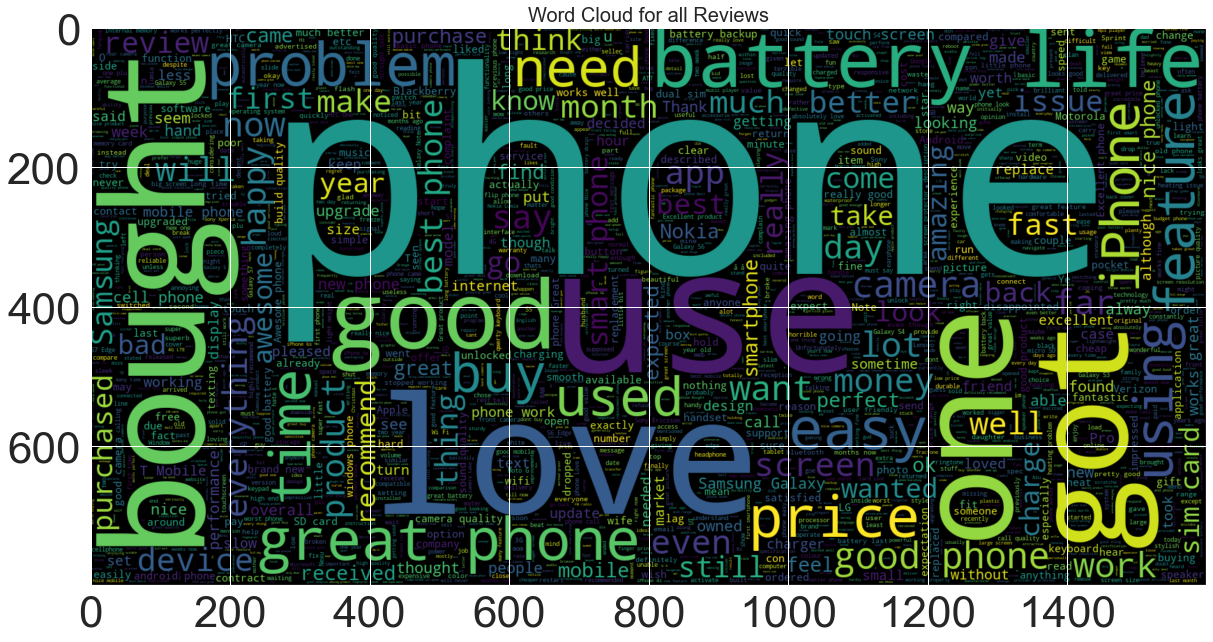

In [80]:
'''
------------------------------------------------------------------------------------------------------------------------
We see that Brazil has only 2 reviews.
So many of the really high rated countries have too small of a sample size to come to an accurate conclusion.
So for this type of analysis we would want a much larger dataset than I have access to right now.
------------------------------------------------------------------------------------------------------------------------
Let's move onto the next part of the analysis.
------------------------------------------------------------------------------------------------------------------------
Let's take a look at which words tend to be more common within the dataset, and then break them into good reviews and bad reviews
to see what people are saying about the products.
------------------------------------------------------------------------------------------------------------------------
'''
#Only take reviews where language = english
english = masterFrame[masterFrame['lang'] == 'en']

analysisFrame = english[['extract', 'score']]
analysisFrame = analysisFrame.dropna()
plt.figure(figsize = (20,20)) # Text Reviews with Poor Ratings
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1600 , height = 800).generate(" ".join(analysisFrame['extract']))
plt.title("Word Cloud for all Reviews", fontsize = 20)
plt.imshow(wc,interpolation = 'bilinear')

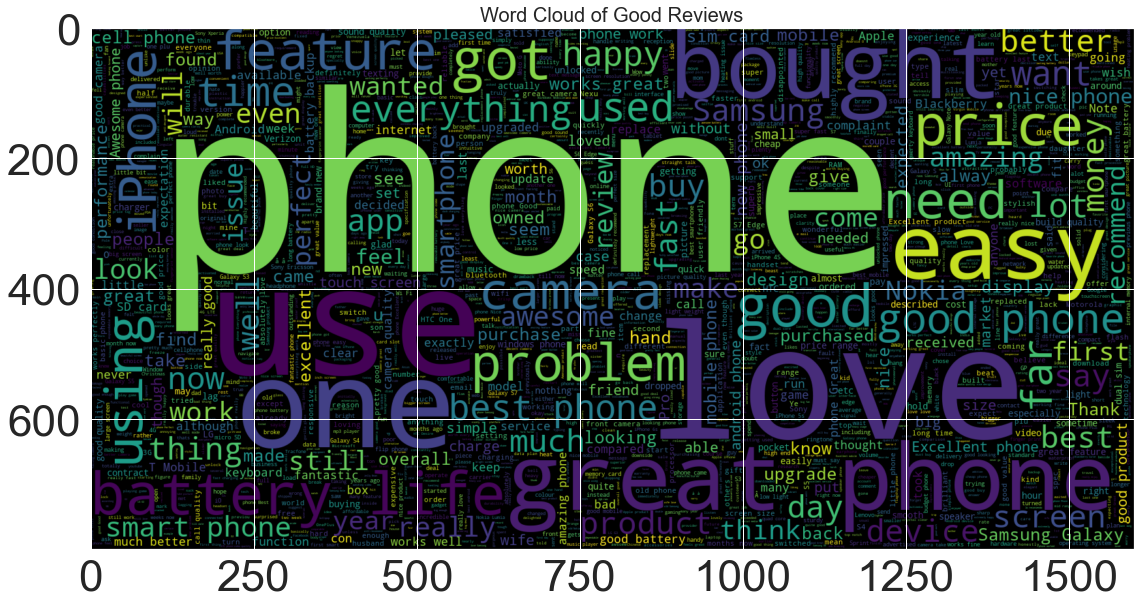

In [81]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's create a Word Cloud for all positive reviews.
------------------------------------------------------------------------------------------------------------------------
'''
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1600 , height = 800).generate(" ".join(analysisFrame[analysisFrame['score'] > 6]['extract']))
plt.title("Word Cloud of Good Reviews", fontsize = 20)
plt.imshow(wc,interpolation = 'bilinear')

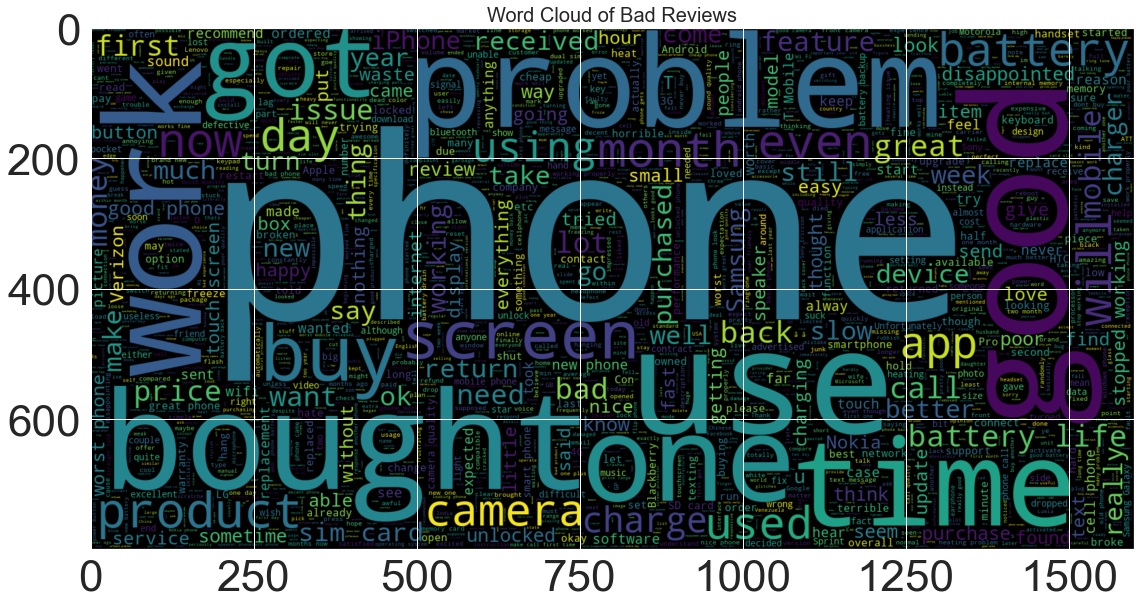

In [82]:
'''
------------------------------------------------------------------------------------------------------------------------
Now we create a word cloud for all negative reviews.
------------------------------------------------------------------------------------------------------------------------
'''
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1600 , height = 800).generate(" ".join(analysisFrame[analysisFrame['score'] < 7]['extract']))
plt.title("Word Cloud of Bad Reviews", fontsize = 20)
plt.imshow(wc,interpolation = 'bilinear')

In [83]:
'''
------------------------------------------------------------------------------------------------------------------------
We see the words 'problem', 'time', 'screen' being a lot more prominent in the bad reviews.
------------------------------------------------------------------------------------------------------------------------
Let's take a look at some records that are bad reviews and have the word 'time' in them.
------------------------------------------------------------------------------------------------------------------------
'''
#Take the reviews where the score is less than 7 and have the word time in them
def printWhereTextIs(text):

    problemText = analysisFrame[analysisFrame['score'] < 7]
    problemText = problemText[problemText['extract'].str.contains(text)]

    #Get the text from the first record
    for i in range(0, 5):
        print(problemText.iloc[i]['extract'])
        print('')

printWhereTextIs('time')

I bought this phone very excited to use it. I agree with all the other reviews stating that trying to use a glass screen protector with it is a nightmare. I have so far has 2 different screen protectors on it and both times they have made it difficult for me to tap on the screen.

Had the Galaxy S5 and thought it was time to uograde. The S8 has a larger screen and takes good pictures but honestly I think the S5 is every bit as good and in fact I like its size better. In my personal opinion I wish I had stayed with the S5 instead of dishing out the money for a new phone.

Clunky is the best word for it. The new features are a joke. The Interface is slow and annoying constantly needing to hit a button 2 or three times. And the curved edges effect typing. Extremely regret getting the s8

I was iPhone user for ten years and I never had any connection problem, wifi or making a call, I just switched to Samsung and wifi is disconnecting so many times consuming my data. I tried everything I fo

In [84]:
'''
------------------------------------------------------------------------------------------------------------------------
From a quick glance there doesn't seem to be much we can gain from this knowledge.
So we will disregard the word time for now.
------------------------------------------------------------------------------------------------------------------------
'''
printWhereTextIs('problem')

I've now found that i'm in a group of people that have carried their phone in their pocket without problems until the S8. Day one screen has crack from being in my pocket. Bluetooth on my 1st trip struggles to stay connected. Good news.....battery life is great and lots of great features.

I was iPhone user for ten years and I never had any connection problem, wifi or making a call, I just switched to Samsung and wifi is disconnecting so many times consuming my data. I tried everything I found on forums but no solution yet. :(

#1) The problem with "The Edge" is that physics kinda demands a little friction. You can't touch the front 'cause that's where all the buttons are, but now you can't touch the edge either? How do you hold it without Something going off?

First, if you get a screen protector, good luck! The screen protector Verizon put on my phone made it virtually impossible for the touch screen to work without pushing extremely hard. It was way too much effort to reply to email

In [85]:
'''
------------------------------------------------------------------------------------------------------------------------
There doesn't seem to be much to gain from the word problem either.
There are too many different contexts behind the words.
------------------------------------------------------------------------------------------------------------------------
'''
printWhereTextIs('screen')

I've now found that i'm in a group of people that have carried their phone in their pocket without problems until the S8. Day one screen has crack from being in my pocket. Bluetooth on my 1st trip struggles to stay connected. Good news.....battery life is great and lots of great features.

I bought this phone very excited to use it. I agree with all the other reviews stating that trying to use a glass screen protector with it is a nightmare. I have so far has 2 different screen protectors on it and both times they have made it difficult for me to tap on the screen.

It is an extremely advanced and truly a Smart phone. Great apps, great look. BUT, the durability is that of a fresh egg. Don't consider this phone without insurance. The screen is fragile and one crack voids warranty. Won't buy another Samsung based on their lack of support for a poor design.

I have always been a Samsung fan, especially with their phones. Unfortunately, the S8, in my opinion, is no flagship phone. The S7 E

In [86]:
'''
------------------------------------------------------------------------------------------------------------------------
Some decent information here is that a large amount of the bad reviews are about the screen.
More specifically the screen breaking.
Even though these reviews are from multiple different phones, analysis could be conducted on one particular phone very easily.
But that falls out of the scope of the project.
So for now we will move on.
------------------------------------------------------------------------------------------------------------------------
'''
print('End')

End


<img src="Pictures/sec2_1.jpg" width="1500" height = "300">

In [87]:
'''
------------------------------------------------------------------------------------------------------------------------
We will not actually clean our data in this section. 
All official cleaning will be done in the PhoneReviews_Cleaning.ipynb file.
This section is for DEMONSTRATION purposes only.
------------------------------------------------------------------------------------------------------------------------
The first thing we are going to do is to try initialize spark.
Once we have initialized it we will find it, and pyspark.
------------------------------------------------------------------------------------------------------------------------
'''
import findspark 
findspark.init() # initialize spark
findspark.find() # find spark
import pyspark
findspark.find() # find pyspark
'''
------------------------------------------------------------------------------------------------------------------------
After that has been done we will import the necessary libraries.
------------------------------------------------------------------------------------------------------------------------
'''
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
'''
------------------------------------------------------------------------------------------------------------------------
Lastly we will create a spark session with the same name as the project.
------------------------------------------------------------------------------------------------------------------------
'''
conf = pyspark.SparkConf().setAppName('Phone_Reviews').setMaster('local') # create a spark session
sc = pyspark.SparkContext(conf=conf) # create a spark context
spark = SparkSession(sc) # create a spark session
'''
------------------------------------------------------------------------------------------------------------------------
The very last thing we will do is import a csv file into a spark dataframe.
We set inferSchema to true so that the data types are automatically guessed, instead of us having to manually set them.
------------------------------------------------------------------------------------------------------------------------
'''
df = spark.read.csv('Phone Reviews/phone_user_review_file_1.csv', header=True, inferSchema=True) # import csv file into a spark dataframe
df.show() # show the spark dataframe

+--------------------+---------+----+-------+----------------+-------------------+-----+---------+--------------------+--------------------+--------------------+
|           phone_url|     date|lang|country|          source|             domain|score|score_max|             extract|              author|             product|
+--------------------+---------+----+-------+----------------+-------------------+-----+---------+--------------------+--------------------+--------------------+
|/cellphones/samsu...| 5/2/2017|  en|     us|Verizon Wireless|verizonwireless.com| 10.0|       10|As a diehard Sams...|          CarolAnn35|   Samsung Galaxy S8|
|/cellphones/samsu...|4/28/2017|  en|     us|     Phone Arena|     phonearena.com| 10.0|       10|Love the phone. t...|           james0923|   Samsung Galaxy S8|
|/cellphones/samsu...| 5/4/2017|  en|     us|          Amazon|         amazon.com|  6.0|       10|Adequate feel. Ni...|            R. Craig|"Samsung Galaxy S...|
|/cellphones/samsu...| 5/2/2

In [88]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's see how many records we are working with.
------------------------------------------------------------------------------------------------------------------------
'''
df.count() # show the number of records in the spark dataframe

374910

In [89]:

'''
------------------------------------------------------------------------------------------------------------------------
We see that we are working with over 350,000 records.
But we also have quite a few files with reviews.
So let's load them all at once.
------------------------------------------------------------------------------------------------------------------------
The first step will be to get a list of all the files.
------------------------------------------------------------------------------------------------------------------------
'''
files = os.listdir('Phone Reviews') # get all the files in the directory
print(files) # print the files

['phone_user_review_file_1.csv', 'phone_user_review_file_2.csv', 'phone_user_review_file_3.csv', 'phone_user_review_file_4.csv', 'phone_user_review_file_5.csv', 'phone_user_review_file_6.csv']


In [90]:
'''
------------------------------------------------------------------------------------------------------------------------
After that we can grab all the csv files and store them each into a spark dataframe.
After that we can then store the spark dataframes into a list.
Which we can loop through and concatenate.
------------------------------------------------------------------------------------------------------------------------
'''

dataframes = [] # create an empty list
for file in files: # loop through the files
    if file.endswith('.csv') and not file.endswith('1.csv'): # if the file ends with .csv, but exclude the first file which we already loaded
        dataframes.append(spark.read.csv('Phone Reviews/' + file, header=True, inferSchema=True)) # append the spark dataframe to the list

for frame in dataframes: # loop through the spark dataframes
    df = df.union(frame) # concatenate the spark dataframes

print(f'''
      --------------------------------------------------
      There are {df.count()} records in the dataframe.
      --------------------------------------------------           
      ''')


      --------------------------------------------------
      There are 1415133 records in the dataframe.
      --------------------------------------------------           
      


In [91]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's take a look at the dataframe we have created to make sure everything looks good.
------------------------------------------------------------------------------------------------------------------------
'''
df.show() # show the spark dataframe

+--------------------+---------+----+-------+----------------+-------------------+-----+---------+--------------------+--------------------+--------------------+
|           phone_url|     date|lang|country|          source|             domain|score|score_max|             extract|              author|             product|
+--------------------+---------+----+-------+----------------+-------------------+-----+---------+--------------------+--------------------+--------------------+
|/cellphones/samsu...| 5/2/2017|  en|     us|Verizon Wireless|verizonwireless.com| 10.0|       10|As a diehard Sams...|          CarolAnn35|   Samsung Galaxy S8|
|/cellphones/samsu...|4/28/2017|  en|     us|     Phone Arena|     phonearena.com| 10.0|       10|Love the phone. t...|           james0923|   Samsung Galaxy S8|
|/cellphones/samsu...| 5/4/2017|  en|     us|          Amazon|         amazon.com|  6.0|       10|Adequate feel. Ni...|            R. Craig|"Samsung Galaxy S...|
|/cellphones/samsu...| 5/2/2

In [92]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's print out a schema to see what the data types are.
------------------------------------------------------------------------------------------------------------------------
'''
df.schema # print the schema

StructType([StructField('phone_url', StringType(), True), StructField('date', StringType(), True), StructField('lang', StringType(), True), StructField('country', StringType(), True), StructField('source', StringType(), True), StructField('domain', StringType(), True), StructField('score', DoubleType(), True), StructField('score_max', IntegerType(), True), StructField('extract', StringType(), True), StructField('author', StringType(), True), StructField('product', StringType(), True)])

In [93]:
'''
------------------------------------------------------------------------------------------------------------------------
Alright, from here we can see what is going on quite well. We have a dataset where people have left reviews about their phones.
And a rating, this allows for sentiment analysis as we can take all the reviews above X stars and label them as positive, and all the reviews below X stars and label them as negative.
------------------------------------------------------------------------------------------------------------------------
But before anything else, we want to only take the reviews that are in english.
------------------------------------------------------------------------------------------------------------------------
'''
df = df.filter(df.lang == 'en')
df.count() # show the number of records in the spark dataframe

554746

In [94]:
'''
------------------------------------------------------------------------------------------------------------------------
Just over 500k records.
Now we can look at taking the coumns we are interested in.
We definately want the review text (extract) and the rating (score) columns.
------------------------------------------------------------------------------------------------------------------------
The extract will provide us with our text data, and the score will provide us with our labels.
------------------------------------------------------------------------------------------------------------------------
'''
df = df.select('extract', 'score')
df.show()

+--------------------+-----+
|             extract|score|
+--------------------+-----+
|As a diehard Sams...| 10.0|
|Love the phone. t...| 10.0|
|Adequate feel. Ni...|  6.0|
|Never disappointe...|  9.2|
|I've now found th...|  4.0|
|I am the type of ...| 10.0|
|The way this Sams...|  4.0|
|I bought this pho...|  6.0|
|It is an extremel...|  6.0|
|"Great phone with...|  8.0|
|I initially wasn'...| 10.0|
|this arrived a we...| 10.0|
|I traded in my ga...| 10.0|
|I have always bee...|  6.0|
|Took the risk and...| 10.0|
|I moved from the ...| 10.0|
|I love the phone ...|  8.0|
|This phone makes ...| 10.0|
|This is my third ...| 10.0|
|Battery life is g...|  8.0|
+--------------------+-----+
only showing top 20 rows



In [95]:
'''
------------------------------------------------------------------------------------------------------------------------
We have quite a few records and probably wouldn't miss too many if we dropped null values instead of trying to fill them.
Filling null values puts the model at risk of potentially being overfit. 
So as long as not too many values get dropped, we will drop them.
------------------------------------------------------------------------------------------------------------------------
'''
df = df.dropna() # drop any null values
df.count()

545426

In [96]:
'''
------------------------------------------------------------------------------------------------------------------------
We didn't lose too many values, so we can continue with the rest of the cleaning.
The first thing we are going to do is create a binary label based on the score.
For now we will use 6 as the divider between good and bad.
------------------------------------------------------------------------------------------------------------------------
The idea is that records below 6 will typically be more negative than records above 6. 
------------------------------------------------------------------------------------------------------------------------
'''
df = df.withColumn('sentiment', functions.when(df.score > 5, 1).otherwise(0))
df.show()

+--------------------+-----+---------+
|             extract|score|sentiment|
+--------------------+-----+---------+
|As a diehard Sams...| 10.0|        1|
|Love the phone. t...| 10.0|        1|
|Adequate feel. Ni...|  6.0|        1|
|Never disappointe...|  9.2|        1|
|I've now found th...|  4.0|        0|
|I am the type of ...| 10.0|        1|
|The way this Sams...|  4.0|        0|
|I bought this pho...|  6.0|        1|
|It is an extremel...|  6.0|        1|
|"Great phone with...|  8.0|        1|
|I initially wasn'...| 10.0|        1|
|this arrived a we...| 10.0|        1|
|I traded in my ga...| 10.0|        1|
|I have always bee...|  6.0|        1|
|Took the risk and...| 10.0|        1|
|I moved from the ...| 10.0|        1|
|I love the phone ...|  8.0|        1|
|This phone makes ...| 10.0|        1|
|This is my third ...| 10.0|        1|
|Battery life is g...|  8.0|        1|
+--------------------+-----+---------+
only showing top 20 rows



In [97]:
'''
------------------------------------------------------------------------------------------------------------------------
We will once again get rid of any unnecessary columns.
Such as the score column which no longer serves a purpose.
------------------------------------------------------------------------------------------------------------------------
'''
df = df.select('extract', 'sentiment')
df.show()

+--------------------+---------+
|             extract|sentiment|
+--------------------+---------+
|As a diehard Sams...|        1|
|Love the phone. t...|        1|
|Adequate feel. Ni...|        1|
|Never disappointe...|        1|
|I've now found th...|        0|
|I am the type of ...|        1|
|The way this Sams...|        0|
|I bought this pho...|        1|
|It is an extremel...|        1|
|"Great phone with...|        1|
|I initially wasn'...|        1|
|this arrived a we...|        1|
|I traded in my ga...|        1|
|I have always bee...|        1|
|Took the risk and...|        1|
|I moved from the ...|        1|
|I love the phone ...|        1|
|This phone makes ...|        1|
|This is my third ...|        1|
|Battery life is g...|        1|
+--------------------+---------+
only showing top 20 rows



In [98]:
'''
------------------------------------------------------------------------------------------------------------------------
We don't need to run spark anymore so we will stop the session here.
------------------------------------------------------------------------------------------------------------------------
'''
sc.stop()

In [99]:
'''
------------------------------------------------------------------------------------------------------------------------
To demonstrate the cleaning we will use a dummy dataframe to easily illustrate what is going to happen.
------------------------------------------------------------------------------------------------------------------------
'''
testing = pd.DataFrame({'Random Text': ['<b>This is a test</b>', 'This is !another test.?', '<div>This is a third test</div>','caresses','photographs','corpora','better'], 'Sentiment': [1, 0, 1,1,1,1,0]})
testing

,Random Text,Sentiment
0,<b>This is a test</b>,1
1,This is !another test.?,0
2,<div>This is a third test</div>,1
3,caresses,1
4,photographs,1
5,corpora,1
6,better,0


In [100]:
'''
------------------------------------------------------------------------------------------------------------------------
The first thing we will do is to convert the text to lowercase.
------------------------------------------------------------------------------------------------------------------------
'''
testing['Random Text'] = testing['Random Text'].str.lower()
testing

,Random Text,Sentiment
0,<b>this is a test</b>,1
1,this is !another test.?,0
2,<div>this is a third test</div>,1
3,caresses,1
4,photographs,1
5,corpora,1
6,better,0


In [101]:
'''
------------------------------------------------------------------------------------------------------------------------
We will then remove any html tags.
------------------------------------------------------------------------------------------------------------------------
'''
testing['Random Text'] = testing['Random Text'].str.replace('<.*?>', '')
testing

C:\Users\kglez\AppData\Local\Temp\ipykernel_24152\2558730584.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  testing['Random Text'] = testing['Random Text'].str.replace('<.*?>', '')


,Random Text,Sentiment
0,this is a test,1
1,this is !another test.?,0
2,this is a third test,1
3,caresses,1
4,photographs,1
5,corpora,1
6,better,0


In [102]:
'''
------------------------------------------------------------------------------------------------------------------------
Afterwards we will remove any punctuation.
------------------------------------------------------------------------------------------------------------------------
'''
testing['Random Text'] = testing['Random Text'].str.replace('[^\w\s]', '')
testing

C:\Users\kglez\AppData\Local\Temp\ipykernel_24152\1348565962.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  testing['Random Text'] = testing['Random Text'].str.replace('[^\w\s]', '')


,Random Text,Sentiment
0,this is a test,1
1,this is another test,0
2,this is a third test,1
3,caresses,1
4,photographs,1
5,corpora,1
6,better,0


In [103]:
'''
------------------------------------------------------------------------------------------------------------------------
Lastly we will remove any stopwords.
------------------------------------------------------------------------------------------------------------------------

def remove stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    
testing['Random Text'] = testing['Random Text'].apply(remove_stopwords)

------------------------------------------------------------------------------------------------------------------------
'''
testing['Random Text'] = testing['Random Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))]))
testing

,Random Text,Sentiment
0,test,1
1,another test,0
2,third test,1
3,caresses,1
4,photographs,1
5,corpora,1
6,better,0


In [104]:
'''
------------------------------------------------------------------------------------------------------------------------
The stopwords are a list of words that are commonly used in the english language which don't provide much value to the model.
------------------------------------------------------------------------------------------------------------------------
'''
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [105]:
'''
------------------------------------------------------------------------------------------------------------------------
Here we demonstrate how lemmatization can affect certain words.
------------------------------------------------------------------------------------------------------------------------
'''
#Lemmatize the words
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text): #Lemmatize the words
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            pos = pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(word.lower())
    return " ".join(final_text)

testing['Random Text'] = testing['Random Text'].apply(lemmatize_words)
testing

,Random Text,Sentiment
0,test,1
1,another test,0
2,third test,1
3,caress,1
4,photograph,1
5,corpus,1
6,well,0


In [ ]:
'''
------------------------------------------------------------------------------------------------------------------------
We see that corpora and better becomes corpus and well.
This is because the lemmatization method looks for normalized version of the word.
------------------------------------------------------------------------------------------------------------------------
'''
print('End of Section')

<img src="Pictures/sec3.jpg" width="1500" height = "300">

In [4]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's load all the numpy arrays we have cleaned and saved.
------------------------------------------------------------------------------------------------------------------------
Sadly the pickle is going to get in the way, so we need to override it.
------------------------------------------------------------------------------------------------------------------------
'''

np_load_old = np.load # save the old numpy load function
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k) # override the numpy load function

#The X_raw folder holds the stemmed data
X_stemmed = np.load('Clean Numpy Arrays/X_raw.npy')
y_stemmed = np.load('Clean Numpy Arrays/y_raw.npy')

X_lem = np.load('Clean Numpy Arrays/X_lem.npy')
y_lem = np.load('Clean Numpy Arrays/y_lem.npy')


In [5]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's make sure the arrays are consistent.
------------------------------------------------------------------------------------------------------------------------
'''
print(f'''
      The shape of the X_stemmed array is {X_stemmed.shape}
      The shape of the y_stemmed array is {y_stemmed.shape}
      The shape of the X_lem array is {X_lem.shape}
      The shape of the y_lem array is {y_lem.shape}
      ''')


      The shape of the X_stemmed array is (550531,)
      The shape of the y_stemmed array is (550531,)
      The shape of the X_lem array is (550531,)
      The shape of the y_lem array is (550531,)
      


In [6]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's take a look at our data.
We can print out the first 3 records.
------------------------------------------------------------------------------------------------------------------------
'''
print(X_lem[:3])
print(y_lem[:3])

['diehard samsung fan every samsung phone since series started, favorite upgrade far. amaze review think people may defective device need replaced. battery life amazing.'
 'love phone. phone sleek smooth beautiful highly recommend phone regret get phone.'
 "adequate feel. nice heft. processor's still sluggish apps installed. samsung want vacuum data apps require access needed. else new."]
[1 1 0]


In [7]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's see how balanced the records are.
------------------------------------------------------------------------------------------------------------------------
'''
print(f'''
      There are {np.count_nonzero(y_stemmed == 1)} 1s in the y_stemmed array
      There are {np.count_nonzero(y_stemmed == 0)} 0s in the y_stemmed array
      ''')


      There are 385578 1s in the y_stemmed array
      There are 164953 0s in the y_stemmed array
      


In [8]:
'''
------------------------------------------------------------------------------------------------------------------------
There are too few negative records. 
So we can utilize the SMOTE algorithm to create more negative records.
This generates synthetic records which are very similar to the existing records
------------------------------------------------------------------------------------------------------------------------
'''
print('Moving On')

Moving On


<h1>Stemming and SMOTE

In [9]:

'''
------------------------------------------------------------------------------------------------------------------------
There are quite a few negative reviews but there are an overwhelming amount of positive reviews.
------------------------------------------------------------------------------------------------------------------------
So we will consider using SMOTE from here.
We will test both with and without SMOTE.
------------------------------------------------------------------------------------------------------------------------
'''
def tokenize(X_inputted):
    max_fatures = 2000 # we will only take the top 2000 words
    tokenizer = Tokenizer(num_words=max_fatures, split=' ') # create the tokenizer
    tokenizer.fit_on_texts(X_inputted) # fit the tokenizer on the X_stemmed array
    X = tokenizer.texts_to_sequences(X_inputted) # convert the X_stemmed array to sequences
    X = pad_sequences(X) # pad the sequences
    return X

X = tokenize(X_stemmed)
'''
------------------------------------------------------------------------------------------------------------------------
This will save the values as int values.
What we want instead is to make sure that the values are float values.
So we will convert the values to float values.
------------------------------------------------------------------------------------------------------------------------
'''
X = np.asarray(X).astype('float32')
y = np.asarray(y_stemmed).astype('float32')

In [10]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's check the shape of the arrays.
------------------------------------------------------------------------------------------------------------------------
'''
X.shape

(550531, 76)

In [11]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's utilize SMOTE to create more negative records.
------------------------------------------------------------------------------------------------------------------------
'''
sm = SMOTE(random_state=42)
X_res_stemmed, y_res_stemmed = sm.fit_resample(X, y)

KeyboardInterrupt: 

In [ ]:
'''
------------------------------------------------------------------------------------------------------------------------
Smote should have successfully created more negative records to match the amount of positive records.
------------------------------------------------------------------------------------------------------------------------
'''
print(f'''
      There are {np.count_nonzero(y_res_stemmed == 1)} 1s in the y_stemmed array
      There are {np.count_nonzero(y_res_stemmed == 0)} 0s in the y_stemmed array
      ''')


      There are 385578 1s in the y_stemmed array
      There are 385578 0s in the y_stemmed array
      


In [ ]:
'''
------------------------------------------------------------------------------------------------------------------------
Looks like the SMOTE was successful.
------------------------------------------------------------------------------------------------------------------------
Let's check the type to make sure that it is correct.
------------------------------------------------------------------------------------------------------------------------
'''
print(type(X_res_stemmed[0][0]))
print(type(y_res_stemmed[0]))

<class 'numpy.float32'>
<class 'numpy.float32'>


In [ ]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's take a look and see what the tokenized array looks like.
------------------------------------------------------------------------------------------------------------------------
'''
print(X_res_stemmed[0])

[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.500e+01 6.000e+00
 6.700e+01 6.070e+02 1.910e+02 3.300e+01 2.700e+01 1.940e+02 6.700e+01
 3.000e+00 1.690e+02 1.980e+02 1.000e+00 3.700e+02 1.106e+03 9.000e+00
 3.300e+01 8.600e+01 1.300e+01 9.820e+02 1.840e+02 2.800e+01 1.320e+02
 2.000e+00 6.500e+01 1.610e+02 4.200e+01 1.140e+02 1.100e+01 1.000e+00
 1.560e+02 5.000e+00 1.730e+02 2.460e+02 4.190e+02 4.500e+01 1.800e+01
 6.000e+00 7.010e+02 1.860e+02 2.100e+01 9.100e+01 8.000e+00 3.800e+01
 1.898e+03 1.000e+00 3.200e+01 9.300e+01 7.000e+00 3.110e+02]


In [ ]:
'''
------------------------------------------------------------------------------------------------------------------------
Everything looks good.
------------------------------------------------------------------------------------------------------------------------
Time to split the data into training and testing sets.
We will do a 80/20 split.
With 80% training data and 20% testing data.
------------------------------------------------------------------------------------------------------------------------
'''
#import train_test_split

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res_stemmed, y_res_stemmed, test_size=0.2, random_state=42)

In [ ]:
'''
------------------------------------------------------------------------------------------------------------------------
lot's of testing was done to see which model would work best.
Lot's of different parameters were tested.
These were the best ones found.
------------------------------------------------------------------------------------------------------------------------
'''
max_fatures = 200 # we will only take the top 200 words
embed_dim = 32 # the embedding dimension
lstm_out = 30  # the number of LSTM units
#The embedded dimension is the number of dimensions in which you want to represent your word vectors.

model = Sequential() # create the model
model.add(Embedding(max_fatures, embed_dim,input_length = X_train.shape[1])) # add the embedding layer
#The input length is the length of the input sequences.
model.add(SpatialDropout1D(0.4)) # add the spatial dropout layer
#The spartial dropout layer is a form of regularization.
#It drops out entire 1D feature maps instead of individual elements.
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0)) # add the LSTM layer
model.add(Dense(2,activation='sigmoid')) # add the output layer
opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)# create the optimizer
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt,metrics = ['accuracy']) # compile the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 76, 32)            6400      
                                                                 
 spatial_dropout1d (SpatialD  (None, 76, 32)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 30)                7560      
                                                                 
 dense (Dense)               (None, 2)                 62        
                                                                 
Total params: 14,022
Trainable params: 14,022
Non-trainable params: 0
_________________________________________________________________
None


c:\Users\kglez\miniconda3\envs\yip\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
'''
------------------------------------------------------------------------------------------------------------------------
Here we fit the model with a batch size of 128 and 3 epochs.
More epochs will be used for the final model but for now 3 epochs will do.
------------------------------------------------------------------------------------------------------------------------
'''
batch_size = 128
model.fit(X_train, y_train, epochs = 2, batch_size=batch_size, verbose = 1)

Epoch 1/2
4820/4820 [==============================] - 36s 7ms/step - loss: 0.4537 - accuracy: 0.7787
Epoch 2/2
4820/4820 [==============================] - 35s 7ms/step - loss: 0.3744 - accuracy: 0.8271


In [ ]:
'''
------------------------------------------------------------------------------------------------------------------------
We see the model performing quite well but let's print out some confusion matrices to see how well it is doing.
------------------------------------------------------------------------------------------------------------------------
'''
predictions = model.predict(X_test) # get the predictions
predictions

4820/4820 [==============================] - 14s 3ms/step


array([[0.37728032, 0.6269351 ],
       [0.06625048, 0.8190495 ],
       [0.9443689 , 0.07535081],
       ...,
       [0.39788595, 0.5024836 ],
       [0.6474149 , 0.4007595 ],
       [0.32059947, 0.6485483 ]], dtype=float32)

In [ ]:
'''
------------------------------------------------------------------------------------------------------------------------
We see that the predictions are in the form of probabilities.
What is the probability that a review is 0 or 1.
------------------------------------------------------------------------------------------------------------------------
Let's look at the second record to get an idea of this.
------------------------------------------------------------------------------------------------------------------------
'''
predictions[1]

array([0.06625048, 0.8190495 ], dtype=float32)

In [ ]:
'''
------------------------------------------------------------------------------------------------------------------------
We see that the model is 94% sure that the review is 1.
Let's convert all of these into 1 hot encoded values.
Based on which one is the highest.
------------------------------------------------------------------------------------------------------------------------
'''
predictions = np.argmax(predictions, axis=1) # convert the predictions to 1 hot encoded values
predictions

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [ ]:
'''
------------------------------------------------------------------------------------------------------------------------
Now that we have the predictions correctly formatted.
We can get a classification report.
------------------------------------------------------------------------------------------------------------------------
'''
classification_report(y_test, predictions)

'              precision    recall  f1-score   support\n\n         0.0       0.87      0.81      0.84     76921\n         1.0       0.82      0.88      0.85     77311\n\n    accuracy                           0.85    154232\n   macro avg       0.85      0.85      0.85    154232\nweighted avg       0.85      0.85      0.85    154232\n'

Text(33.0, 0.5, 'Truth')

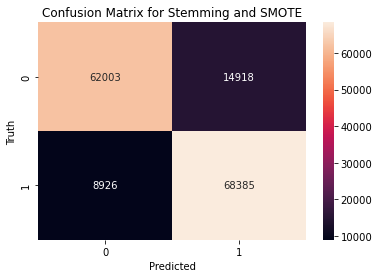

In [ ]:
'''
------------------------------------------------------------------------------------------------------------------------
We see that the model is performing quite well.
Is isn't particularly struggling with any of aspects like precision, recall or f1-score.
And the accuracy is quite good for a model that only has 2 epochs.
------------------------------------------------------------------------------------------------------------------------
'''
cm = confusion_matrix(y_true=y_test, y_pred=predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Stemming and SMOTE')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
'''
------------------------------------------------------------------------------------------------------------------------
The model is quite respectable.
------------------------------------------------------------------------------------------------------------------------
Let's see how well the lemmatization performs in comparison.
------------------------------------------------------------------------------------------------------------------------
From this point onwards the steps won't be as detailed as it will just be a repeat of what was done above.
------------------------------------------------------------------------------------------------------------------------
'''
print('End of section')


End of section


<h1>Lemmatization and SMOTE

In [ ]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's tokenize the lemmatized array.
And convert the values to float values.
------------------------------------------------------------------------------------------------------------------------
'''
X = tokenize(X_lem)
X = np.asarray(X).astype('float32')
y = np.asarray(y_lem).astype('float32')

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [ ]:
batch_size = 128
model.fit(X_train, y_train, epochs = 2, batch_size=batch_size, verbose = 1)

Epoch 1/2
4820/4820 [==============================] - 32s 6ms/step - loss: 0.5022 - accuracy: 0.7451
Epoch 2/2
4820/4820 [==============================] - 31s 6ms/step - loss: 0.4475 - accuracy: 0.7830


In [ ]:
predictions = model.predict(X_test) # get the predictions
predictions = np.argmax(predictions, axis=1) # convert the predictions to 1 hot encoded values
classification_report(y_test, predictions)

4820/4820 [==============================] - 12s 2ms/step


'              precision    recall  f1-score   support\n\n         0.0       0.80      0.79      0.80     76921\n         1.0       0.80      0.80      0.80     77311\n\n    accuracy                           0.80    154232\n   macro avg       0.80      0.80      0.80    154232\nweighted avg       0.80      0.80      0.80    154232\n'

Text(33.0, 0.5, 'Truth')

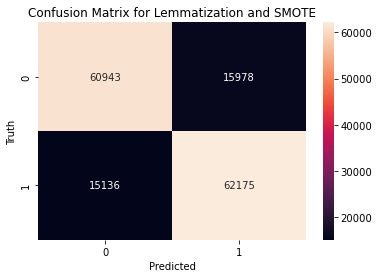

In [ ]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's get the accuracy score.
------------------------------------------------------------------------------------------------------------------------
'''
cm = confusion_matrix(y_true=y_test, y_pred=predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Lemmatization and SMOTE')
plt.xlabel('Predicted')
plt.ylabel('Truth')

<h1>Stemming without SMOTE

In [12]:
'''
------------------------------------------------------------------------------------------------------------------------
Let's try without SMOTE now.
------------------------------------------------------------------------------------------------------------------------
'''
X = tokenize(X_stemmed)
X = np.asarray(X).astype('float32')
y = np.asarray(y_stemmed).astype('float32')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X.shape

(550531, 76)

In [14]:
max_fatures = 200 # we will only take the top 1500 words
embed_dim = 32 # we will embed the words into 200 dimensions
lstm_out = 30 # we will use 300 LSTM units

model = Sequential() # create the model
model.add(Embedding(max_fatures, embed_dim,input_length = X_train.shape[1])) # add the embedding layer
model.add(SpatialDropout1D(0.4)) # add the spatial dropout layer
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0)) # add the LSTM layer
model.add(Dense(2,activation='sigmoid')) # add the output layer
opt = tf.keras.optimizers.Adam(lr=1e-2, decay=1e-2)# create the optimizer
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy']) # compile the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 76, 32)            6400      
                                                                 
 spatial_dropout1d (SpatialD  (None, 76, 32)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 30)                7560      
                                                                 
 dense (Dense)               (None, 2)                 62        
                                                                 
Total params: 14,022
Trainable params: 14,022
Non-trainable params: 0
_________________________________________________________________
None


c:\Users\kglez\miniconda3\envs\yip\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
batch_size = 128
model.fit(X_train, y_train, epochs = 2, batch_size=batch_size, verbose = 1)

Epoch 1/2
3441/3441 [==============================] - 32s 8ms/step - loss: 0.4274 - accuracy: 0.8005
Epoch 2/2
3441/3441 [==============================] - 26s 8ms/step - loss: 0.3998 - accuracy: 0.8148


In [16]:
predictions = model.predict(X_test) # get the predictions
predictions = np.argmax(predictions, axis=1) # convert the predictions to 1 hot encoded values
classification_report(y_test, predictions)

3441/3441 [==============================] - 10s 3ms/step


'              precision    recall  f1-score   support\n\n         0.0       0.76      0.60      0.67     33066\n         1.0       0.84      0.92      0.88     77041\n\n    accuracy                           0.82    110107\n   macro avg       0.80      0.76      0.77    110107\nweighted avg       0.82      0.82      0.82    110107\n'

3441/3441 [==============================] - 10s 3ms/step


Text(33.0, 0.5, 'Truth')

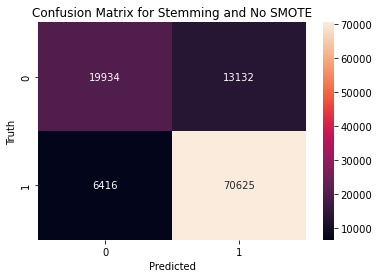

In [17]:
predictions = model.predict(X_test) # get the predictions
predictions = np.argmax(predictions, axis=1) # convert the predictions to 1 hot encoded values
cm = confusion_matrix(y_true=y_test, y_pred=predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Stemming and No SMOTE')
plt.xlabel('Predicted')
plt.ylabel('Truth')

<h1>Lemmatization without SMOTE

In [18]:
'''
------------------------------------------------------------------------------------------------------------------------
We call the lemmatized data.
------------------------------------------------------------------------------------------------------------------------
'''
X = tokenize(X_lem)
X = np.asarray(X).astype('float32')
y = np.asarray(y_lem).astype('float32')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 128
model.fit(X_train, y_train, epochs = 2, batch_size=batch_size, verbose = 1)

Epoch 1/2
3441/3441 [==============================] - 25s 7ms/step - loss: 0.4473 - accuracy: 0.7891
Epoch 2/2
3441/3441 [==============================] - 24s 7ms/step - loss: 0.4213 - accuracy: 0.8029


In [19]:
predictions = model.predict(X_test) # get the predictions
predictions = np.argmax(predictions, axis=1) # convert the predictions to 1 hot encoded values
classification_report(y_test, predictions)

3441/3441 [==============================] - 9s 2ms/step


'              precision    recall  f1-score   support\n\n         0.0       0.74      0.57      0.64     33066\n         1.0       0.83      0.91      0.87     77041\n\n    accuracy                           0.81    110107\n   macro avg       0.78      0.74      0.76    110107\nweighted avg       0.80      0.81      0.80    110107\n'

3441/3441 [==============================] - 8s 2ms/step


Text(33.0, 0.5, 'Truth')

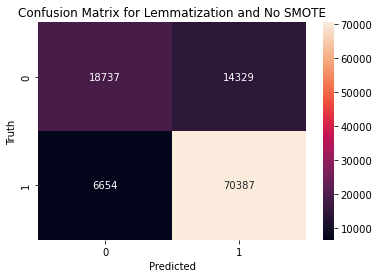

In [20]:
'''
------------------------------------------------------------------------------------------------------------------------
We get a prediction.
------------------------------------------------------------------------------------------------------------------------
'''
predictions = model.predict(X_test) # get the predictions
predictions = np.argmax(predictions, axis=1) # convert the predictions to 1 hot encoded values
cm = confusion_matrix(y_true=y_test, y_pred=predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Lemmatization and No SMOTE')
plt.xlabel('Predicted')
plt.ylabel('Truth')

<h1>Final Model

In [21]:
X_stemmed = np.load('Clean Numpy Arrays/X_raw.npy')
y_stemmed = np.load('Clean Numpy Arrays/y_raw.npy')

In [22]:
X = tokenize(X_stemmed)
X = np.asarray(X).astype('float32')
y = np.asarray(y_stemmed).astype('float32')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
max_fatures = 2000 # we will only take the top 2000 words
embed_dim = 128 # we will embed the words into 128 dimensions
lstm_out = 200 # we will use 200 LSTM units

model = Sequential() # create the model
model.add(Embedding(max_fatures, embed_dim,input_length = X_train.shape[1])) # add the embedding layer
model.add(SpatialDropout1D(0.4)) # add the spatial dropout layer
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0)) # add the LSTM layer
model.add(Dense(2,activation='sigmoid')) # add the output layer
opt = tf.keras.optimizers.Adam(lr=1e-2, decay=1e-2)# create the optimizer
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy']) # compile the model
print(model.summary())

batch_size = 128
model.fit(X_train, y_train, epochs = 15, batch_size=batch_size, verbose = 1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 76, 128)           256000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 76, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 200)               263200    
                                                                 
 dense_1 (Dense)             (None, 2)                 402       
                                                                 
Total params: 519,602
Trainable params: 519,602
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15


c:\Users\kglez\miniconda3\envs\yip\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


3441/3441 [==============================] - 40s 11ms/step - loss: 0.3409 - accuracy: 0.8524
Epoch 2/15
3441/3441 [==============================] - 38s 11ms/step - loss: 0.3016 - accuracy: 0.8716
Epoch 3/15
3441/3441 [==============================] - 38s 11ms/step - loss: 0.2893 - accuracy: 0.8778
Epoch 4/15
3441/3441 [==============================] - 39s 11ms/step - loss: 0.2812 - accuracy: 0.8814
Epoch 5/15
3441/3441 [==============================] - 39s 11ms/step - loss: 0.2743 - accuracy: 0.8849
Epoch 6/15
3441/3441 [==============================] - 39s 11ms/step - loss: 0.2683 - accuracy: 0.8876
Epoch 7/15
3441/3441 [==============================] - 39s 11ms/step - loss: 0.2629 - accuracy: 0.8903
Epoch 8/15
3441/3441 [==============================] - 37s 11ms/step - loss: 0.2573 - accuracy: 0.8930
Epoch 9/15
3441/3441 [==============================] - 37s 11ms/step - loss: 0.2528 - accuracy: 0.8950
Epoch 10/15
3441/3441 [==============================] - 39s 11ms/step - lo

In [24]:
predictions = model.predict(X_test) # get the predictions
predictions = np.argmax(predictions, axis=1) # convert the predictions to 1 hot encoded values
classification_report(y_test, predictions)

3441/3441 [==============================] - 12s 4ms/step


'              precision    recall  f1-score   support\n\n         0.0       0.83      0.77      0.80     33066\n         1.0       0.90      0.93      0.92     77041\n\n    accuracy                           0.88    110107\n   macro avg       0.87      0.85      0.86    110107\nweighted avg       0.88      0.88      0.88    110107\n'

3441/3441 [==============================] - 13s 4ms/step


Text(33.0, 0.5, 'Truth')

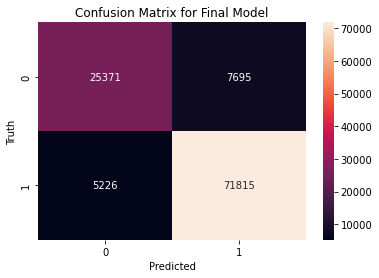

In [25]:
predictions = model.predict(X_test) # get the predictions
predictions = np.argmax(predictions, axis=1) # convert the predictions to 1 hot encoded values
cm = confusion_matrix(y_true=y_test, y_pred=predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Final Model')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [26]:
def getX(text):
    frame = {'extract': text}
    dataframeTemp = pd.DataFrame(frame,index=[0])

    processingPipeline_stem = make_pipeline(makeItLowerCase(), replaceHTMLelements(), dropTheNullValues(), removeStopWords(), StemTheWords())

    dataframeTemp2 = processingPipeline_stem.fit_transform(dataframeTemp)

    numpyFrame = dataframeTemp2.to_numpy()

    X = numpyFrame[:,0]
    
    return X

X = getX("This is my first smartphone so I have nothing to compare it to, but I'm very satisfied and it seems to have the specifications and capabilities of a much more expensive phone and does everything well.")

C:\Users\kglez\AppData\Local\Temp\ipykernel_25696\411938327.py:113: FutureWarning: The default value of regex will change from True to False in a future version.
  X['extract'] = X['extract'].str.replace('<.*?>', '')


In [27]:
X

array(["first smartphon noth compar to, i'm satisfi seem specif capabl much expens phone everyth well."],
      dtype=object)

In [28]:
'''
------------------------------------------------------------------------------------------------------------------------
IMPORTANT:
The tokinzer needs to be set to the same tokenizer as the one used to train the model.
So it needs to be set to the X_stemmed array.
------------------------------------------------------------------------------------------------------------------------
'''
X_inputted = X_stemmed
max_fatures = 2000 # we will only take the top 2000 words
tokenizer = Tokenizer(num_words=max_fatures, split=' ') # create the tokenizer
tokenizer.fit_on_texts(X_inputted) # fit the tokenizer on the X_stemmed array

In [29]:
'''
------------------------------------------------------------------------------------------------------------------------
Sometimes the cache gets in the way on jupyter, an odd way I found to fix it is to send a shape of (X,1) to the predictor.
And this will fix the issue.
------------------------------------------------------------------------------------------------------------------------
'''
X = tokenizer.texts_to_sequences('hello world') # convert the X_stemmed array to sequences
X = pad_sequences(X) # pad the sequences
prediction = model.predict(X)

1/1 [==============================] - 0s 274ms/step


In [30]:
'''
------------------------------------------------------------------------------------------------------------------------
We tokinize the inputted text and then pad it.
------------------------------------------------------------------------------------------------------------------------
'''
X = getX("This is my first smartphone so I have nothing to compare it to, but I'm very satisfied and it seems to have the specifications and capabilities of a much more expensive phone and does everything well.")
X = tokenizer.texts_to_sequences(X) # convert the X_stemmed array to sequences
X = pad_sequences(X) # pad the sequences

C:\Users\kglez\AppData\Local\Temp\ipykernel_25696\411938327.py:113: FutureWarning: The default value of regex will change from True to False in a future version.
  X['extract'] = X['extract'].str.replace('<.*?>', '')


In [31]:
X

array([[ 80, 203, 341, 258,   8, 120, 404, 210, 793, 818,  94, 561,   3,
        126,  77]])

In [32]:
prediction = model.predict(X)
prediction

1/1 [==============================] - 0s 272ms/step


array([[0.1438544, 0.8503278]], dtype=float32)

In [33]:
from tkinter import *

root = Tk()
root.title('Sentiment Analysis')
root.geometry('500x330')

#Clear textbox
def clear():
    reviewFrame.delete(1.0,END)
    label.config(text='')

#Grab the text from the textboc
def get_text():
    label.config(text=reviewFrame.get(1.0,END))
    text = reviewFrame.get(1.0,END)
    X = getX(text)
    X = tokenizer.texts_to_sequences(X) # convert the X_stemmed array to sequences
    X = pad_sequences(X) # pad the sequences
    prediction = model.predict(X)
    oneHot = np.argmax(prediction, axis=1)
    if oneHot[0] == 1:
        label.config(text='This was a positive review')
    else:
        label.config(text='This was a negative review')

label = Label(root, text = "Leave a review")
label.pack(pady=10)

reviewFrame = Text(root, height=10, width=50, font=('Arial', 12))
reviewFrame.pack(pady=10)

label = Label(root,text = '')
label.pack(pady=10)

button_frame = Frame(root)
button_frame.pack()

clear_button = Button(button_frame, text='Clear', command=clear)
clear_button.grid(row=0, column=0)

get_text_button = Button(button_frame, text='Submit Review', command=get_text)
get_text_button.grid(row=0, column=1,padx=20)

root.mainloop()

1/1 [==============================] - 0s 16ms/step


C:\Users\kglez\AppData\Local\Temp\ipykernel_25696\411938327.py:113: FutureWarning: The default value of regex will change from True to False in a future version.
  X['extract'] = X['extract'].str.replace('<.*?>', '')


1/1 [==============================] - 0s 14ms/step


C:\Users\kglez\AppData\Local\Temp\ipykernel_25696\411938327.py:113: FutureWarning: The default value of regex will change from True to False in a future version.
  X['extract'] = X['extract'].str.replace('<.*?>', '')


1/1 [==============================] - 0s 13ms/step


C:\Users\kglez\AppData\Local\Temp\ipykernel_25696\411938327.py:113: FutureWarning: The default value of regex will change from True to False in a future version.
  X['extract'] = X['extract'].str.replace('<.*?>', '')


1/1 [==============================] - 0s 15ms/step


C:\Users\kglez\AppData\Local\Temp\ipykernel_25696\411938327.py:113: FutureWarning: The default value of regex will change from True to False in a future version.
  X['extract'] = X['extract'].str.replace('<.*?>', '')


1/1 [==============================] - 0s 14ms/step


C:\Users\kglez\AppData\Local\Temp\ipykernel_25696\411938327.py:113: FutureWarning: The default value of regex will change from True to False in a future version.
  X['extract'] = X['extract'].str.replace('<.*?>', '')


1/1 [==============================] - 0s 14ms/step


C:\Users\kglez\AppData\Local\Temp\ipykernel_25696\411938327.py:113: FutureWarning: The default value of regex will change from True to False in a future version.
  X['extract'] = X['extract'].str.replace('<.*?>', '')


1/1 [==============================] - 0s 14ms/step


C:\Users\kglez\AppData\Local\Temp\ipykernel_25696\411938327.py:113: FutureWarning: The default value of regex will change from True to False in a future version.
  X['extract'] = X['extract'].str.replace('<.*?>', '')


1/1 [==============================] - 0s 15ms/step


C:\Users\kglez\AppData\Local\Temp\ipykernel_25696\411938327.py:113: FutureWarning: The default value of regex will change from True to False in a future version.
  X['extract'] = X['extract'].str.replace('<.*?>', '')


1/1 [==============================] - 0s 13ms/step


C:\Users\kglez\AppData\Local\Temp\ipykernel_25696\411938327.py:113: FutureWarning: The default value of regex will change from True to False in a future version.
  X['extract'] = X['extract'].str.replace('<.*?>', '')


1/1 [==============================] - 0s 14ms/step


C:\Users\kglez\AppData\Local\Temp\ipykernel_25696\411938327.py:113: FutureWarning: The default value of regex will change from True to False in a future version.
  X['extract'] = X['extract'].str.replace('<.*?>', '')


1/1 [==============================] - 0s 13ms/step


C:\Users\kglez\AppData\Local\Temp\ipykernel_25696\411938327.py:113: FutureWarning: The default value of regex will change from True to False in a future version.
  X['extract'] = X['extract'].str.replace('<.*?>', '')


<img src="Pictures/sec4.jpg" width="1500" height = "300">

In [ ]:
#Import gated recurrent unit
from tensorflow.keras.layers import GRU

max_fatures = 2000 # we will only take the top 2000 words
embed_dim = 128 # we will embed the words into 128 dimensions
lstm_out = 200 # we will use 200 LSTM units

model = Sequential() # create the model
model.add(Embedding(max_fatures, embed_dim,input_length = X_train.shape[1])) # add the embedding layer
model.add(SpatialDropout1D(0.4)) # add the spatial dropout layer
model.add(GRU(lstm_out, dropout=0.2, recurrent_dropout=0)) # add the LSTM layer
model.add(Dense(2,activation='sigmoid')) # add the output layer
opt = tf.keras.optimizers.Adam(lr=1e-2, decay=1e-2)# create the optimizer
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy']) # compile the model
print(model.summary())

batch_size = 128
model.fit(X_train, y_train, epochs = 3, batch_size=batch_size, verbose = 1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 76, 128)           256000    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 76, 128)          0         
 lDropout1D)                                                     
                                                                 
 gru (GRU)                   (None, 200)               198000    
                                                                 
 dense_3 (Dense)             (None, 2)                 402       
                                                                 
Total params: 454,402
Trainable params: 454,402
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3


c:\Users\kglez\miniconda3\envs\yip\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


3441/3441 [==============================] - 37s 10ms/step - loss: 0.3381 - accuracy: 0.8536
Epoch 2/3
3441/3441 [==============================] - 35s 10ms/step - loss: 0.3010 - accuracy: 0.8720
Epoch 3/3
3441/3441 [==============================] - 35s 10ms/step - loss: 0.2887 - accuracy: 0.8781
